In [1]:
import os
import logging
import numpy as np
from matplotlib import pyplot as plt
from photometry.NERSC.paths import *
from photometry import *

logger = logging.getLogger('EBV1000')
setup_logging()

run = 'north'
#run = 'south'
region = run[0].upper()
path_data = path_data(region)
path_randoms = path_randoms(region)
path_mctool = path_mctool(region)
path_legacysim = os.path.join(path_dir,'legacysim','dr9','ebv1000shaper',run,'file0_rs0_skip0','merged','matched_input.fits')

In [2]:
def isELG_colors(gflux=None, rflux=None, zflux=None, south=True, gmarg=0., grmarg=0., rzmarg=0., primary=None):
    """
    Apply ELG selection with box enlarged by ``gmarg``, ``grmarg``, ``rzmarg``.

    Base selection from https://github.com/desihub/desitarget/blob/master/py/desitarget/cuts.py.
    """
    #print(gmarg,grmarg,rzmarg)
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()

    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))

    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20 - gmarg                          # bright cut.
    elg &= r - z > 0.3 - rzmarg                    # blue cut.
    elg &= r - z < 1.6 + rzmarg                    # red cut.
    elg &= g - r < -1.2*(r - z) + 1.6 + grmarg     # OII flux cut.

    # ADM cuts that are unique to the north or south.
    if south:
        elg &= g < 23.4 + gmarg # faint cut.
        # ADM south has the FDR cut to remove stars and low-z galaxies.
        elg &= g - r < 1.15*(r - z) - 0.15 + grmarg
    else:
        elg &= g < 23.5 + gmarg # faint cut.
        elg &= g - r < 1.15*(r - z) - 0.20 + grmarg # remove stars and low-z galaxies.

    return elg

def mask_ts(self,key_flux='EFLUX',region=region,gmarg=0.,grmarg=0.,rzmarg=0.,gcut=-np.inf):
    mask = isELG_colors(gflux=self['{}_G'.format(key_flux)],rflux=self['{}_R'.format(key_flux)],
                        zflux=self['{}_Z'.format(key_flux)],south=region=='S',
                        gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg)
    mask &= self['{}_G'.format(key_flux)] > gcut
    return mask

TargetSelection.mask_ts = mask_ts

# Let's first compare legacysim to ELG targets, when applying TS

In [3]:
# legacysim
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
#legacysim['MATCHED'] = legacysim['DISTANCE'] < 0.15/3600.
logger.info('Found {:d}/{:d} matches.'.format(legacysim['MATCHED'].sum(),legacysim.size))
legacysim.set_estimated_flux(key='INPUT_EFLUX',key_transmission='INPUT_MW_TRANSMISSION',key_flux='INPUT_FLUX')
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask_tsin = legacysim.mask_maskbit(key_nobs='INPUT_NOBS',key_maskbits='INPUT_MASKBITS') & legacysim.mask_ts(key_flux='INPUT_EFLUX',region=region)
mask_tsout = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & legacysim.mask_ts(key_flux='EFLUX',region=region) & legacysim['MATCHED']
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim_data = legacysim[mask_tsout]
legacysim_randoms = legacysim[mask_tsin]

[ 000000.02 ]: 01-21 11:30  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/legacysim/dr9/ebv1000shaper/north/file0_rs0_skip0/merged/matched_input.fits.
[ 000000.61 ]: 01-21 11:30  TargetSelection INFO     Selecting 123182/123182 targets.
[ 000001.26 ]: 01-21 11:30  EBV1000         INFO     Found 107848/123182 matches.
[ 000001.62 ]: 01-21 11:30  EBV1000         INFO     Selecting 15414 (output)/14914 (input) injected sources.


In [4]:
# ELG targets, TS applied already
bricknames = np.unique(legacysim['BRICKNAME'])
data = TargetSelection.load_objects(path_data,region=region)
mask = np.in1d(data['BRICKNAME'],bricknames)
mask[:] = True # do not cut data on the same bricks as legacysim
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
data.set_mag_from_flux(key_flux='EFLUX')
mask &= data.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & data.mask_ts(key_flux='EFLUX',region=region)
logger.info('Selecting {:d} targets.'.format(mask.sum()))
data = data[mask]

randoms = TargetSelection.load_objects(path_randoms,region=region)
mask = np.in1d(randoms['BRICKNAME'],bricknames)
mask[:] = True
mask &= randoms.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
randoms = randoms[mask]

def from_map(cat,fields):
    import healpy as hp
    map = Catalogue.load(path_hp)
    theta,phi = utils.radec_to_thphi(cat['RA'],cat['DEC'])
    hppix = hp.ang2pix(map.header['HPXNSIDE'],theta,phi,nest=map.header['HPXNEST'],lonlat=False)
    for field in fields: cat[field] = map[field][hppix]

[ 000001.97 ]: 01-21 11:30  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/targets_ELG_dr9m/data_N.fits.
[ 000015.46 ]: 01-21 11:31  TargetSelection INFO     Selecting 12324773/12324773 targets.
[ 000035.06 ]: 01-21 11:31  EBV1000         INFO     Selecting 9531848 targets.
[ 000040.89 ]: 01-21 11:31  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/targets_ELG_dr9m/randoms_N.fits.
[ 000064.72 ]: 01-21 11:32  TargetSelection INFO     Selecting 12891392/12891392 targets.


[ 000104.30 ]: 01-21 11:32  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/targets_ELG_dr9m/pixweight.fits.
[ 000104.37 ]: 01-21 11:32  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000104.37 ]: 01-21 11:32  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000104.38 ]: 01-21 11:32  HealpixDensity  INFO     Found 1633 bricks with randoms.


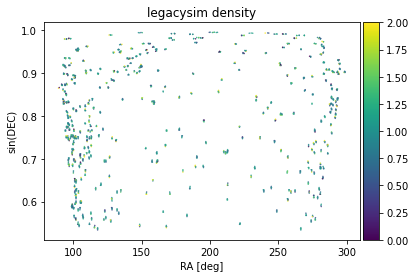

[ 000104.63 ]: 01-21 11:32  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000104.64 ]: 01-21 11:32  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000104.64 ]: 01-21 11:32  HealpixDensity  INFO     Found 1633 bricks with randoms.
[ 000104.64 ]: 01-21 11:32  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000105.58 ]: 01-21 11:32  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000105.59 ]: 01-21 11:32  HealpixDensity  INFO     Found 98007 bricks with randoms.
[ 000106.81 ]: 01-21 11:32  Properties      INFO     Calculating EBV statistics.
[ 000106.89 ]: 01-21 11:32  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0379.
[ 000106.89 ]: 01-21 11:32  Properties      INFO     Calculating EBV statistics.
[ 000106.94 ]: 01-21 11:32  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.1220.
[ 000106.95 ]: 01-21 11:32  Properties      INFO     Calculating GALDEPTH_G statistics.
[ 0

In [ ]:
# Density maps
map = Catalogue.load(path_hp)
legacysim_dens = HealpixDensity(map=map)
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)
legacysim_dens.plot_density_map(title='legacysim density',vmin=0,vmax=2)

legacysim_dens = HealpixDensity(map=map)
#legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

others = [legacysim_dens]
labels = ['DR9','legacysim']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},xedges={'quantiles':[0.02,0.98]})
plt.show()

## No trend with EBV... Let's focus on EBV

In [ ]:
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
denslow = BinnedDensity(ref=data,fields=['EFLUX_G'],ranges=(0.36,1.5),nbins=10)
denslow.set_randoms(randoms=data)
denslow.set_data(data=data[data['EBV']<0.1])
denslow.set_properties(weights='data')
denshigh = denslow.deepcopy()
denshigh.set_data(data=data[data['EBV']>0.1])
denshigh.set_properties(weights='data')
densratio = denshigh/denslow

legacysim_data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
denslow = BinnedDensity(ref=legacysim_data,fields=['EFLUX_G'],ranges=(0.36,1.5),nbins=10)
denslow.set_randoms(randoms=legacysim_data)
denslow.set_data(data=legacysim_data[legacysim_data['EBV']<0.1])
denslow.set_properties(weights='data')
denshigh = denslow.deepcopy()
denshigh.set_data(data=legacysim_data[legacysim_data['EBV']>0.1])
denshigh.set_properties(weights='data')
legacysim_densratio = denshigh/denslow

labels = ['EBV > 0.1 / EBV < 0.1 DR9','legacysim']
densratio.plot_density_variations(prop='EFLUX_G',others=[legacysim_densratio],histos=[denslow,denshigh],var_kwargs={'errors':False,'labels':labels},histo_kwargs={'colors':['g']*2})

# Redo without TS cuts (more stats)

In [ ]:
# legacysim
legacysim.set_estimated_flux(key='INPUT_EFLUX',key_transmission='INPUT_MW_TRANSMISSION',key_flux='INPUT_FLUX')
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask_tsin = legacysim.mask_maskbit(key_nobs='INPUT_NOBS',key_maskbits='INPUT_MASKBITS')
#mask_tsin[:] = True
for b in legacysim.bands: legacysim[b] = legacysim.mag_from_flux(b,key_flux='EFLUX')
mask_tsout = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & legacysim['MATCHED']
#mask_tsout = legacysim['MATCHED']
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim_data = legacysim[mask_tsout]
legacysim_randoms = legacysim[mask_tsin]

In [ ]:
# Density maps
legacysim_dens = HealpixDensity(map=map)
#legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

others = []
labels = ['legacysim']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    legacysim_dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},xedges={'quantiles':[0.1,0.95]})
    
plt.show()

## Very small trend (2% between 0.02 and 0.15) with EBV

# Next, look at flux bias and variance as a function of EBV

In [ ]:
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
legacysim = legacysim[legacysim['MATCHED']]

from scipy import special,stats
def estimate_std(tab):
    # trick to estimate standard deviation in presence of outliers
    return np.median(np.abs(tab-np.median(tab)))/(2.**0.5*special.erfinv(1./2.))
from photometry.utils import Binning

from_map(legacysim,fields=['STARDENS'])

#fields = ['EBV'] + ['PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z']
fields = ['EBV'] + ['PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z']

for xlabel in fields:
    fig,lax = plt.subplots(ncols=3,nrows=2,sharex=False,sharey=False,figsize=(16,6))
    fig.subplots_adjust(hspace=0.4,wspace=0.4)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        legacysim['DELTA_FLUX_{}'.format(b)] = (legacysim['FLUX_{}'.format(b)]-legacysim['INPUT_FLUX_{}'.format(b)]) #/legacysim['MW_TRANSMISSION_{}'.format(b)]
        legacysim.plot_scatter(ax,prop1=xlabel,prop2='DELTA_FLUX_{}'.format(b),xedges={'quantiles':[0.01,0.99]},yedges={'quantiles':[0.01,0.99]})
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
    lax = lax[len(bands):]
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=legacysim[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic='median')[0]
        yerr = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic=estimate_std)[0]
        counts = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic='count')[0]
        yerr *= 1/counts**0.5
        ax.errorbar(x,y,yerr)
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
        ax.set_ylabel('DELTA_FLUX_{}'.format(b))
        ax.set_xlabel(xlabel)
    plt.show()

## Maybe small trend of DELTA_FLUX_G,R with EBV? (actually most of the trends are due to dividing by transmission). Let's look at magnitudes, maybe something will show up

In [ ]:
for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=5,nrows=2,sharex=False,sharey=False,figsize=(20,6))
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    bands = ['G','R','Z'] + ['GR','RZ']
    for ax,b in zip(lax,bands):
        if b == 'GR':
            legacysim['DELTA_{}'.format(b)] = legacysim['DELTA_G'] - legacysim['DELTA_R']
        elif b == 'RZ':
            legacysim['DELTA_{}'.format(b)] = legacysim['DELTA_R'] - legacysim['DELTA_Z']
        else:
            legacysim['DELTA_{}'.format(b)] = utils.flux_to_mag(legacysim['FLUX_{}'.format(b)].clip(1e-16)/legacysim['MW_TRANSMISSION_{}'.format(b)])
            legacysim['DELTA_{}'.format(b)] -= utils.flux_to_mag(legacysim['INPUT_FLUX_{}'.format(b)].clip(1e-16)/legacysim['INPUT_MW_TRANSMISSION_{}'.format(b)])
            #legacysim['DELTA_{}'.format(b)] = utils.flux_to_mag(legacysim['FLUX_{}'.format(b)].clip(1e-16))
            #legacysim['DELTA_{}'.format(b)] -= utils.flux_to_mag(legacysim['INPUT_FLUX_{}'.format(b)].clip(1e-16))
        legacysim.plot_scatter(ax,prop1=xlabel,prop2='DELTA_{}'.format(b),xedges={'quantiles':[0.01,0.99]},yedges={'quantiles':[0.01,0.99]})
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
    lax = lax[len(bands):]

    for ax,b in zip(lax,bands):
        xedges = Binning(samples=legacysim[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_{}'.format(b)],bins=xedges,statistic='median')[0]
        yerr = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_{}'.format(b)],bins=xedges,statistic=estimate_std)[0]
        counts = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_{}'.format(b)],bins=xedges,statistic='count')[0]
        yerr *= 1/counts**0.5
        ax.errorbar(x,y,yerr)
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
        ax.set_ylabel('DELTA_{}'.format(b))
        ax.set_xlabel(xlabel)
    plt.show()

## Again, nothing striking. Let's reproduce what Ashley found with MCTool

In [ ]:
fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(6,6))
dens.plot_density_variations(ax=ax,others=[],prop='EBV',histos=[dens],var_kwargs={'labels':'DR9'},leg_kwargs={},xedges={'quantiles':[0.1,0.9]})
ebv = np.linspace(*ax.get_xlim(),num=10)
model = 1. - .25/.15*ebv # Ashley's fit
norm = 1.04 # just for plotting purposes
model = model/np.mean(model)/norm - 1.

truth = TargetSelection.load_objects(path_truth,tracer='ELG',region=None,case_sensitive=False)
truth.set_flux_from_mag(key='FLUX')
truth['REDSHIFT'] = truth['hsc_mizuki_photoz_best']
truth.region = region
mask = np.all([~np.isnan(truth[b]) for b in truth.bands],axis=0)
truth = truth[mask]

# Ashley's prediction, see: https://github.com/desihub/LSS/blob/master/Sandbox/imaging/ELGEBV.ipynb
def predict_additional_transmission(ebv,flux,b):
    transmission = 10.**(-0.4*0.6*TargetSelection.EXT_COEFFS[b]*ebv)
    return transmission + (1.-transmission)*special.erf(2.*flux)

correlation = np.ones((3,3))*.5 #just given them all correlation of 0.5 for now
np.fill_diagonal(correlation,1.)
std = np.array([0.03,0.05,0.1])
flux_covariance = correlation*std*std[:,None]
efficiency = []
for ebv_ in ebv:
    mc = MCTool(truth=truth,seed=42)
    mc.set_sel_params(sn_band_min=6,sn_flat_min=None,sn_red_min=None)
    mc.set_sim_params(flux_covariance=flux_covariance,flux_adbias=0.,flux_mulbias=1.)
    mc.sim['EBV'] = ebv_
    mc.sim.set_estimated_transmission(key='EMW_TRANSMISSION')
    mc.sim.set_estimated_transmission(key='MW_TRANSMISSION')
    mc.sim['MW_TRANSMISSION_G'] *= predict_additional_transmission(ebv=mc.sim['EBV'],flux=mc.truth['FLUX_G'],b='G')
    #for b in mc.sim.bands:
    #    mc.sim['MW_TRANSMISSION_{}'.format(b)] *= 10**(-0.4*0.25*mc.sim.EXT_COEFFS[b]*mc.sim['EBV'])
    mc()
    efficiency.append(mc.get_efficiency())
efficiency = np.array(efficiency)/np.mean(efficiency)/norm - 1.

ax.plot(ebv,model,label='empirical fit',color='k')
ax.plot(ebv,efficiency,label='MC prediction',color='r')
ax.legend()
plt.show()

## Let's compare Ashley's predicted flux multiplicative bias (EBV, FLUX_G) with legacysim measurements

In [ ]:
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
legacysim = legacysim[legacysim['MATCHED']]

from mpl_toolkits.axes_grid1 import make_axes_locatable

legacysim.set_estimated_flux(key='INPUT_EFLUX',key_transmission='INPUT_MW_TRANSMISSION',key_flux='INPUT_FLUX')
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=3,nrows=3,sharex=False,sharey=False,figsize=(16,10))
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        #legacysim['BIAS_FLUX_{}'.format(b)] = legacysim['EFLUX_{}'.format(b)]/legacysim['INPUT_EFLUX_{}'.format(b)]-1.
        legacysim['BIAS_FLUX_{}'.format(b)] = legacysim['EFLUX_{}'.format(b)]-legacysim['INPUT_EFLUX_{}'.format(b)]
        legacysim.plot_scatter(ax,prop1=xlabel,prop2='EFLUX_{}'.format(b),propc='BIAS_FLUX_{}'.format(b),vmin=0.,vmax=0.2,clabel='BIAS_FLUX_{}'.format(b),xedges={'quantiles':[0.01,0.99]},yedges={'quantiles':[0.01,0.99]})
    lax = lax[len(bands):]
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=legacysim[xlabel],quantiles=[0.01,0.99]).edges
        yedges = Binning(samples=legacysim['EFLUX_{}'.format(b)],range=[0.01,0.6]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = (yedges[:-1] + yedges[1:])/2.
        values = legacysim['BIAS_FLUX_{}'.format(b)]
        z = stats.binned_statistic_2d(legacysim[xlabel],legacysim['EFLUX_{}'.format(b)],values=values,bins=[xedges,yedges],statistic='median')[0]
        im = ax.pcolormesh(x,y,z.T)
        ax.set_ylabel('EFLUX_{}'.format(b))
        ax.set_xlabel(xlabel)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right',size='5%',pad=0.05)
        cbar = plt.colorbar(im,cax=cax)
        cbar.set_label('BIAS_FLUX_{}'.format(b),rotation=90)
        ax.set_title('Binned version of the above')
    
    lax = lax[len(bands):]
    def predict_additional_transmission(ebv,eflux,b):
        transmission = 10.**(-0.4*0.6*TargetSelection.EXT_COEFFS[b]*ebv)
        return transmission + (1.-transmission)*special.erf(2.*eflux)
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=legacysim[xlabel],quantiles=[0.01,0.99]).edges
        yedges = Binning(samples=legacysim['EFLUX_{}'.format(b)],range=[0.01,0.6]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = (yedges[:-1] + yedges[1:])/2.
        #values = legacysim['EFLUX_{}'.format(b)]/legacysim['INPUT_EFLUX_{}'.format(b)]/predict_additional_transmission(legacysim['EBV'],legacysim['INPUT_EFLUX_{}'.format(b)],b)-1.
        values = legacysim['EFLUX_{}'.format(b)]/predict_additional_transmission(legacysim['EBV'],legacysim['INPUT_EFLUX_{}'.format(b)],b)-legacysim['INPUT_EFLUX_{}'.format(b)]
        z = stats.binned_statistic_2d(legacysim[xlabel],legacysim['EFLUX_{}'.format(b)],values=values,bins=[xedges,yedges],statistic='median')[0]
        im = ax.pcolormesh(x,y,z.T)
        ax.set_ylabel('EFLUX_{}'.format(b))
        ax.set_xlabel(xlabel)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right',size='5%',pad=0.05)
        cbar = plt.colorbar(im,cax=cax)
        cbar.set_label('BIAS_FLUX_{}'.format(b),rotation=90)
        ax.set_title('Dividing by prediction')
    
    plt.show()

## More BIAS_FLUX_G variations after dividing by prediction: legacysim measurements look opposite to Ashley's prediction :(

## Miscellaneous

In [ ]:
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
logger.info('Found {:d}/{:d} matches.'.format(legacysim['MATCHED'].sum(),legacysim.size))

mask_i = legacysim.mask_maskbit(key_nobs='INPUT_NOBS',key_maskbits='INPUT_MASKBITS')
mask_o = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
#mask_i[:] = True
#mask_o[:] = True
mask_o = mask_o & legacysim['MATCHED']

#for b in ['G','R','Z']:
    #mask = legacysim['NOBS_%s' % b] != 0
    #print((legacysim['NOBS_%s' % b][mask] != legacysim['INPUT_NOBS_%s' % b][mask]).sum())
    #plt.scatter(legacysim['EBV'][mask],legacysim['NOBS_%s' % b][mask] - legacysim['SIM_NOBS_%s' % b][mask])
    #plt.show()

oh = plt.hist(legacysim['INPUT_EBV'][mask_o],range=(0,.15),bins=10)
ih = plt.hist(legacysim['INPUT_EBV'][mask_i],range=(0,.15),bins=10)
plt.clf()
plt.plot(oh[1][:-1],oh[0]/ih[0],'k-')
plt.show()

In [ ]:
for xlabel in ['INPUT_EBV']:
    fig,lax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(14,4))
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=legacysim[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        legacysim['DELTAREL_FLUX_{}'.format(b)] = (legacysim['FLUX_{}'.format(b)] - legacysim['INPUT_FLUX_{}'.format(b)])*legacysim['FLUX_IVAR_{}'.format(b)]**0.5
        mask = legacysim['MATCHED']
        yerr = stats.binned_statistic(legacysim[xlabel][mask],legacysim['DELTAREL_FLUX_{}'.format(b)][mask],bins=xedges,statistic=estimate_std)[0]
        ax.plot(x,yerr)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('residual dispersion')
    plt.show()

In [ ]:
legacysim = Catalogue.load(path_legacysim)
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
logger.info('Found {:d}/{:d} matches.'.format(legacysim['MATCHED'].sum(),legacysim.size))
legacysim.set_estimated_flux(key='INPUT_EFLUX',key_transmission='INPUT_MW_TRANSMISSION',key_flux='INPUT_FLUX')
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask_tsin = legacysim.mask_maskbit(key_nobs='INPUT_NOBS',key_maskbits='INPUT_MASKBITS') & legacysim.mask_ts(key_flux='INPUT_EFLUX',region=region)
mask_tsout = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & legacysim.mask_ts(key_flux='EFLUX',region=region) & legacysim['MATCHED']
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
from_map(legacysim,fields=['STARDENS'])
legacysim_data = legacysim[mask_tsout]
legacysim_randoms = legacysim[mask_tsin]

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
bins = np.linspace(0.5,2.5,20)
for iax,(ax,prop) in enumerate(zip(lax,props)):
    quantiles = np.quantile(legacysim_data[prop],q=np.linspace(0.,1.,3))
    cat = legacysim_data
    for iq,(low,up) in enumerate(zip(quantiles[:-1],quantiles[1:])):
        mask = (cat[prop] >= low) & (cat[prop] <= up)
        hist,edges = np.histogram(cat['INPUT_REDSHIFT'][mask],bins=bins,density=True)
        mid = (edges[:-1] + edges[1:])/2.
        ax.plot(mid,hist,label='%s #%d' % (prop,iq+1))
        #ax.hist(legacysim_data['INPUT_REDSHIFT'][mask],density=True,histtype='step',bins=bins,label='quant #%d' % (iq+1))
    ax.set_xlabel('redshift')
    ax.set_ylabel('density')
    ax.legend(loc=4)
plt.show()

In [ ]:
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim = legacysim[legacysim['MATCHED']]
counts = []
for brickname in np.unique(legacysim['BRICKNAME']):
    counts.append(np.sum(legacysim['BRICKNAME'] == brickname))
print('Number of randoms per brick:',np.min(counts),np.max(counts))
legacysim.set_estimated_flux(key='EFLUX',key_transmission='INPUT_MW_TRANSMISSION',key_flux='INPUT_FLUX')
mask = legacysim.mask_ts(key_flux='EFLUX')
legacysim.set_mag_from_flux(key_flux='EFLUX')
legacysim['GR'] = legacysim['G'] - legacysim['R']
legacysim['RZ'] = legacysim['R'] - legacysim['Z']
fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(4,4))
ax.scatter(legacysim['RZ'],legacysim['GR'],color='b')
ax.scatter(legacysim['RZ'][mask],legacysim['GR'][mask],color='r')
ax.set_xlim(-1.,2.)
ax.set_ylim(-0.5,2.)
ax.set_xlabel('$g-r$')
ax.set_ylabel('$r-z$')

In [ ]:
# legacysim
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
#legacysim['MATCHED'] = legacysim['DISTANCE'] < 0.15/3600.
logger.info('Found {:d}/{:d} matches.'.format(legacysim['MATCHED'].sum(),legacysim.size))
from_map(legacysim,fields=['STARDENS'])

gcut = 0.6
#gcut = -np.inf
gmarg = 0.; grmarg = 0.; rzmarg = 0.
#gmarg = -0.29; grmarg = -0.1; rzmarg = -0.1

def photometric_scatter(ebv,region='N',band='G'):
    ccdrms = {'N':{'G':0.016,'R':0.015,'Z':0.019}}[region][band]
    if region == 'N':
        if band in ['G','R']:
            nphotom = 2.*(4000.-1000.)/(0.15-0.025)*(ebv-0.025) + 1000.
        if band in ['Z']:
            nphotom = (1000.-250.)/(0.15-0.025)*(ebv-0.025) + 250.
    return 5.*ccdrms/(1.+ebv*100)

#bias = {'G':0.35,'R':0,'Z':0}
#bias = {'G':0.15,'R':-0.2,'Z':0}
#bias = {'G':0.2,'R':0.2,'Z':0.2}
bias = {'G':0.15,'R':0.15,'Z':0.}
#bias = {'G':0.06,'R':-0.06,'Z':0}

for band in legacysim.bands:
    #scatter_mag = photometric_scatter(legacysim['INPUT_EBV'],region=region,band=band)
    #scatter_mag *= np.random.normal(loc=0.0,scale=1.,size=legacysim.size)
    #print(photometric_scatter(0.025,region=region,band=band))
    #legacysim['BFLUX_{}'.format(band)] = legacysim['FLUX_{}'.format(band)]*10.**(scatter_mag/(-2.5)) * 10**(-0.4*bias[band]*legacysim.EXT_COEFFS[b]*legacysim['INPUT_EBV'])
    legacysim['BFLUX_{}'.format(band)] = legacysim['FLUX_{}'.format(band)]*10**(-0.4*bias[band]*legacysim.EXT_COEFFS[band]*legacysim['INPUT_EBV'])

    
"""
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()
from dustmaps.lenz2017 import Lenz2017Query
lenz = Lenz2017Query()
"""
"""
for b in legacysim.bands:
    c = SkyCoord(ra=legacysim['RA'],dec=legacysim['DEC'],unit='deg',frame='icrs')
    #tmp = 10**(-0.4*legacysim.EXT_COEFFS[b]*(lenz(c)-sfd(c)))
    #tmp[np.isnan(tmp)] = 1.
    #legacysim['FLUX_{}'.format(b)] *= tmp
    #tmp = 10**(0.4*0.2*legacysim.EXT_COEFFS[b]*sfd(c))
    #legacysim['INPUT_FLUX_{}'.format(b)] *= tmp
    #tmp = 10**(-0.4*0.3*legacysim.EXT_COEFFS[b]*sfd(c))
    tmp = 10**(-0.4*0.25*legacysim.EXT_COEFFS[b]*legacysim['INPUT_EBV'])
    legacysim['FLUX_{}'.format(b)] *= tmp
"""

legacysim.set_estimated_flux(key='INPUT_EFLUX',key_transmission='INPUT_MW_TRANSMISSION',key_flux='INPUT_FLUX')
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask_tsin = legacysim.mask_maskbit(key_nobs='INPUT_NOBS',key_maskbits='INPUT_MASKBITS') & legacysim.mask_ts(key_flux='INPUT_EFLUX',region=region)
mask_tsout = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & legacysim.mask_ts(key_flux='EFLUX',region=region,gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg,gcut=gcut) & legacysim['MATCHED']
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim_randoms = legacysim[mask_tsin]
legacysim_data = legacysim[mask_tsout]

legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='BFLUX')
mask_tsout = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & legacysim.mask_ts(key_flux='EFLUX',region=region,gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg,gcut=gcut) & legacysim['MATCHED']
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim_dataebv = legacysim[mask_tsout]


# Density maps
map = Catalogue.load(path_hp)

legacysim_dens = HealpixDensity(map=map)
#legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)

#legacysim_densebv = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_densebv = HealpixDensity(map=map)
legacysim_densebv.set_randoms(randoms=legacysim_randoms)
legacysim_densebv.set_properties()
legacysim_densebv.set_data(data=legacysim_dataebv)

data = TargetSelection.load_objects(path_data,region=region)
mask = data.trues() # do not cut data on the same bricks as legacysim
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
data.set_mag_from_flux(key_flux='EFLUX')
mask &= data.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & data.mask_ts(key_flux='EFLUX',region=region,gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg,gcut=gcut)
logger.info('Selecting {:d} targets.'.format(mask.sum()))

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data[mask])

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

others = [legacysim_dens,legacysim_densebv]
labels = ['DR9','legacysim','legacysim 15% EXT G']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},xedges={'quantiles':[0.02,0.98]})
plt.show()

"""
fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
bins = np.linspace(0.5,2.5,20)
for iax,(ax,prop) in enumerate(zip(lax,props)):
    quantiles = np.quantile(legacysim_data[prop],q=np.linspace(0.,1.,3))
    cat = legacysim_data
    for iq,(low,up) in enumerate(zip(quantiles[:-1],quantiles[1:])):
        mask = (cat[prop] >= low) & (cat[prop] <= up)
        hist,edges = np.histogram(cat['INPUT_REDSHIFT'][mask],bins=bins,density=True)
        mid = (edges[:-1] + edges[1:])/2.
        ax.plot(mid,hist,label='%s #%d' % (prop,iq+1))
        #ax.hist(legacysim_data['INPUT_REDSHIFT'][mask],density=True,histtype='step',bins=bins,label='quant #%d' % (iq+1))
    ax.set_xlabel('redshift')
    ax.set_ylabel('density')
    ax.legend(loc=4)
plt.show()

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
bins = np.linspace(0.5,2.5,20)
for iax,(ax,prop) in enumerate(zip(lax,props)):
    quantiles = np.quantile(legacysim_dataebv[prop],q=np.linspace(0.,1.,3))
    cat = legacysim_dataebv
    for iq,(low,up) in enumerate(zip(quantiles[:-1],quantiles[1:])):
        mask = (cat[prop] >= low) & (cat[prop] <= up)
        hist,edges = np.histogram(cat['INPUT_REDSHIFT'][mask],bins=bins,density=True)
        mid = (edges[:-1] + edges[1:])/2.
        ax.plot(mid,hist,label='%s #%d' % (prop,iq+1))
        #ax.hist(legacysim_data['INPUT_REDSHIFT'][mask],density=True,histtype='step',bins=bins,label='quant #%d' % (iq+1))
    ax.set_xlabel('redshift')
    ax.set_ylabel('density')
    ax.legend(loc=4)
plt.show()
"""

In [ ]:
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
legacysim = legacysim[legacysim['MATCHED']]

fields = ['PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z']
cat = randoms
depth = {}
for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=len(fields),nrows=1,sharex=False,sharey=False,figsize=(len(fields)*5,4),squeeze=False)
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    for iax,(ax,field) in enumerate(zip(lax,fields)):
        xedges = Binning(samples=cat[xlabel],quantiles=[0.03,0.99]).edges
        #xedges = np.linspace(0.03,0.15,10)
        x = (xedges[:-1] + xedges[1:])/2.
        y = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic='median')[0]
        yerr = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic=estimate_std)[0]
        counts = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic='count')[0]
        ax.errorbar(x,y/norm,yerr/norm/counts**0.5)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(field)
        depth[field] = (x,y)
    plt.show()

#fields = ['PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z']

for b in legacysim.bands:
    legacysim['BIAS_FLUX_{}'.format(b)] = legacysim['FLUX_{}'.format(b)]-legacysim['INPUT_FLUX_{}'.format(b)]

#fields = ['FLUX_G','FLUX_R','FLUX_Z']
fields = ['BIAS_FLUX_{}'.format(b) for b in legacysim.bands]
cat = legacysim
#for xlabel in ['EBV']:
for xlabel in fields:
    fig,lax = plt.subplots(ncols=len(fields),nrows=1,sharex=False,sharey=False,figsize=(len(fields)*5,4),squeeze=False)
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    for iax,(ax,field) in enumerate(zip(lax,fields)):
        xedges = Binning(samples=cat[xlabel],quantiles=[0.03,0.99]).edges
        #xedges = np.linspace(0.03,0.15,10)
        x = (xedges[:-1] + xedges[1:])/2.
        y = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic='median')[0]
        yerr = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic=estimate_std)[0]
        counts = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic='count')[0]
        ax.errorbar(x,y/norm,yerr/norm/counts**0.5)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(field)
    plt.show()

In [ ]:
for xlabel in ['BIAS_FLUX_{}'.format(b) for b in legacysim.bands]:
    fig,lax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(16,6))
    fig.subplots_adjust(hspace=0.4,wspace=0.4)
    lax = lax.flatten()
    for ax,b in zip(lax,legacysim.bands):
        field = 'BIAS_FLUX_{}'.format(b)
        legacysim.plot_scatter(ax,prop1=xlabel,prop2=field,xedges={'quantiles':[0.01,0.99]},yedges={'quantiles':[0.01,0.99]})
        mask = (np.abs(cat[xlabel]) < 0.3) & (np.abs(cat[field]) < 0.3)
        print(xlabel,field,'correlation',np.corrcoef(cat[xlabel][mask],cat[field][mask])[0,1])
    plt.show()

# Let's try to reproduce legacysim results with MCtool

In [ ]:
from photometry import *

fields_depth = ['PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z']
cat = randoms
depth = {}
for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=len(fields_depth),nrows=1,sharex=False,sharey=False,figsize=(len(fields_depth)*5,4),squeeze=False)
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    for iax,(ax,field) in enumerate(zip(lax,fields_depth)):
        xedges = Binning(samples=cat[xlabel],quantiles=[0.03,0.99]).edges
        #xedges = np.linspace(0.03,0.15,10)
        x = (xedges[:-1] + xedges[1:])/2.
        y = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic='median')[0]
        yerr = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic=estimate_std)[0]
        counts = stats.binned_statistic(cat[xlabel],cat[field],bins=xedges,statistic='count')[0]
        ax.errorbar(x,y/norm,yerr/norm/counts**0.5)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(field)
        depth[field] = (x,y)
    #plt.show()
    
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
legacysim = legacysim[legacysim['MATCHED']]

fluxbias = {}
for xlabel in ['EBV']:
    fig,lax = plt.subplots(ncols=3,nrows=2,sharex=False,sharey=False,figsize=(16,6))
    fig.subplots_adjust(hspace=0.4,wspace=0.4)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        legacysim['DELTA_FLUX_{}'.format(b)] = (legacysim['FLUX_{}'.format(b)]-legacysim['INPUT_FLUX_{}'.format(b)]) #/legacysim['MW_TRANSMISSION_{}'.format(b)]
        legacysim.plot_scatter(ax,prop1=xlabel,prop2='DELTA_FLUX_{}'.format(b),xedges={'quantiles':[0.01,0.99]},yedges={'quantiles':[0.01,0.99]})
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
    lax = lax[len(bands):]
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=legacysim[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        y = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic='median')[0]
        yerr = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic=estimate_std)[0]
        counts = stats.binned_statistic(legacysim[xlabel],legacysim['DELTA_FLUX_{}'.format(b)],bins=xedges,statistic='count')[0]
        yerr *= 1/counts**0.5
        ax.errorbar(x,y,yerr)
        ax.axhline(y=0,xmin=0,xmax=1,color='r')
        ax.set_ylabel('DELTA_FLUX_{}'.format(b))
        ax.set_xlabel(xlabel)
        fluxbias[b] = (x,y)

dispcorr = {}
for xlabel in ['INPUT_EBV']:
    fig,lax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(14,4))
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=legacysim[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        legacysim['DELTAREL_FLUX_{}'.format(b)] = (legacysim['FLUX_{}'.format(b)] - legacysim['INPUT_FLUX_{}'.format(b)])*legacysim['FLUX_IVAR_{}'.format(b)]**0.5
        yerr = stats.binned_statistic(legacysim[xlabel],legacysim['DELTAREL_FLUX_{}'.format(b)],bins=xedges,statistic=estimate_std)[0]
        ax.plot(x,yerr)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('residual dispersion')
        dispcorr[b] = (x,yerr)

dispabs = {}
for xlabel in ['INPUT_EBV']:
    fig,lax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(14,4))
    fig.subplots_adjust(hspace=0.4,wspace=0.5)
    lax = lax.flatten()
    bands = ['G','R','Z']
    for ax,b in zip(lax,bands):
        xedges = Binning(samples=legacysim[xlabel],quantiles=[0.01,0.99]).edges
        x = (xedges[:-1] + xedges[1:])/2.
        legacysim['DELTAREL_FLUX_{}'.format(b)] = (legacysim['FLUX_{}'.format(b)] - legacysim['INPUT_FLUX_{}'.format(b)])
        yerr = stats.binned_statistic(legacysim[xlabel],legacysim['DELTAREL_FLUX_{}'.format(b)],bins=xedges,statistic=estimate_std)[0]
        ax.plot(x,yerr)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('residual dispersion')
        dispabs[b] = (x,yerr)

#gcut = 0.9
gcut = -np.inf
dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()

data = TargetSelection.load_objects(path_data,region=region)
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask = data.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & data.mask_ts(key_flux='EFLUX',region=region)
logger.info('Selecting {:d} targets.'.format(mask.sum()))
dens.set_data(data=data[mask])

fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(6,6))
dens.plot_density_variations(ax=ax,others=[],prop='EBV',histos=[dens],var_kwargs={'labels':'DR9'},leg_kwargs={},xedges={'quantiles':[0.1,0.9]})
ebv = np.linspace(*ax.get_xlim(),num=10)
model = 1. - .25/.15*ebv # Ashley's fit
norm = 1.04 # just for plotting purposes
model = model/np.mean(model)/norm - 1.

truth = TargetSelection.load_objects(path_truth,tracer='ELG',region=None,case_sensitive=False)
truth.set_flux_from_mag(key='FLUX')
truth['REDSHIFT'] = truth['hsc_mizuki_photoz_best']
truth.region = region
mask = np.all([~np.isnan(truth[b]) for b in truth.bands],axis=0)
truth = truth[mask]

correlation = np.ones((3,3))*0.2 #just give them all correlation of 0.5 for now
correlation[0,1] = correlation[1,0] = 0.5
np.fill_diagonal(correlation,1.)

efficiency = []
bias = {'G':0.10,'R':0.10,'Z':0.10}
#bias = {'G':0.20,'R':0.20,'Z':0.20}
for ebv_ in ebv:
    mc = MCTool(truth=truth,seed=42)
    mc.set_sel_params(sn_band_min=6,sn_flat_min=None,sn_red_min=None)
    #std_scaling = np.array([np.interp(ebv_,dispcorr[b][0],dispcorr[b][1]) for b in legacysim.bands]) 
    #std = std_scaling*np.array([np.interp(ebv_,depth[field][0],depth[field][1])**(-0.5) for field in fields_depth])
    #std = np.array([np.interp(ebv_,dispabs[b][0],dispabs[b][1]) for b in legacysim.bands])
    std = np.array([np.mean(dispabs[b][1]) for b in legacysim.bands])
    #std *= (0.9*(ebv_-0.02)/(0.15-0.02) + 1)
    #std *= (-0.4*(ebv_-0.15)/(0.15-0.02) + 1)*2
    flux_covariance = correlation*std*std[:,None]
    flux_bias = np.array([np.interp(ebv_,fluxbias[b][0],fluxbias[b][1]) for b in legacysim.bands]) 
    #flux_bias[:] = 0
    mc.set_sim_params(flux_covariance=flux_covariance,flux_adbias=flux_bias,flux_mulbias=1.)
    mc.sim['EBV'] = ebv_
    mc.sim.set_estimated_transmission(key='EMW_TRANSMISSION')
    mc.sim.set_estimated_transmission(key='MW_TRANSMISSION')
    #mc.sim['MW_TRANSMISSION_G'] *= predict_additional_transmission(ebv=mc.sim['EBV'],flux=mc.truth['FLUX_G'],b='G')
    for band in mc.sim.bands:
        mc.sim['EMW_TRANSMISSION_{}'.format(band)] *= 10**(0.4*bias[band]*mc.sim.EXT_COEFFS[band]*mc.sim['EBV'])
    mc()
    efficiency.append(mc.get_efficiency())

efficiency = np.array(efficiency)/np.mean(efficiency)/norm - 1.

ax.plot(ebv,model,label='empirical fit',color='k')
ax.plot(ebv,efficiency,label='MC prediction',color='r')

ax.legend()
plt.show()

# Let's look at data v.s. legacysim mag and color distribution

In [ ]:
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
from_map(legacysim,fields=['STARDENS'])

bias = {'G':0.20,'R':0.20,'Z':0.20}
for band in legacysim.bands:
    legacysim['BFLUX_{}'.format(band)] = legacysim['FLUX_{}'.format(band)]*10**(-0.4*bias[band]*legacysim.EXT_COEFFS[band]*legacysim['INPUT_EBV'])

legacysim.set_estimated_flux(key='INPUT_EFLUX',key_transmission='INPUT_MW_TRANSMISSION',key_flux='INPUT_FLUX')
mask_tsin = legacysim.mask_maskbit(key_nobs='INPUT_NOBS',key_maskbits='INPUT_MASKBITS') & legacysim.mask_ts(key_flux='INPUT_EFLUX',region=region)
legacysim_randoms = legacysim[mask_tsin]

legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask_tsout = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & legacysim.mask_ts(key_flux='EFLUX',region=region) & legacysim['MATCHED']
legacysim_data = legacysim[mask_tsout]

legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='BFLUX')
mask_tsout = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & legacysim.mask_ts(key_flux='EFLUX',region=region) & legacysim['MATCHED']
legacysim_dataebv = legacysim[mask_tsout]
for b in legacysim.bands: legacysim_dataebv['FLUX_{}'.format(b)] = legacysim_dataebv['FLUX_{}'.format(b)]

#legacysim_data = legacysim[legacysim['MATCHED']]

# ELG targets, TS applied already
bricknames = np.unique(legacysim['BRICKNAME'])
data = TargetSelection.load_objects(path_data,region=region)
mask = np.in1d(data['BRICKNAME'],bricknames)
#mask[:] = True # do not cut data on the same bricks as legacysim
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask &= data.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & data.mask_ts(key_flux='EFLUX',region=region)
logger.info('Selecting {:d} targets.'.format(mask.sum()))
data = data[mask]

prop = 'EBV'
quantiles = np.quantile(legacysim_data[prop],q=np.linspace(0.,1.,4))
quantiles = list(zip(quantiles[:-1],quantiles[1:]))

cats = [data,legacysim_data,legacysim_dataebv]
titles = ['DR9','legacysim','legacysim -20% EBV']
fields = ['G','R','Z','G-R','R-Z']
for cat in cats:
    cat.set_mag_from_flux(key_flux='EFLUX')
    cat['G-R'] = cat['G'] - cat['R']
    cat['R-Z'] = cat['R'] - cat['Z']

fig,lax = plt.subplots(ncols=len(fields),nrows=len(cats),sharex=False,sharey=True,figsize=(4*len(fields),4*len(cats)))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
for ifield,(field,laxf) in enumerate(zip(fields,lax.T)):
    edges = Binning(samples=data[field],quantiles=[0.001,0.999],nbins=15).edges
    for iax,(ax,cat,title) in enumerate(zip(laxf,cats,titles)):
        for iq,(low,up) in enumerate(quantiles):
            mask = (cat[prop] >= low) & (cat[prop] <= up)
            hist,edges = np.histogram(cat[field][mask],bins=edges,density=True)
            mid = (edges[:-1] + edges[1:])/2.
            ax.plot(mid,hist,label='%s #%d' % (prop,iq+1),linestyle='-')
        ax.set_xlabel(field)
        ax.set_ylabel('density')
        ax.set_title(title)
        if ifield == 0: ax.legend(loc=2)
plt.show()

In [ ]:
# legacysim
legacysim = TargetSelection.load_objects(path_legacysim,radecbox=None,tracer='ELG',region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
#legacysim['MATCHED'] = legacysim['DISTANCE'] < 0.15/3600.
logger.info('Found {:d}/{:d} matches.'.format(legacysim['MATCHED'].sum(),legacysim.size))
from_map(legacysim,fields=['STARDENS'])

#gcut = 0.8
gcut = -np.inf
#gmarg = 0.; grmarg = 0.; rzmarg = 0.
gmarg = -0.29; grmarg = -0.1; rzmarg = -0.1

#bias = {'G':0.35,'R':0,'Z':0}
#bias = {'G':0.15,'R':-0.2,'Z':0}
#bias = {'G':0.2,'R':0.2,'Z':0.2}
if run == 'south':
    #bias = {'G':-0.1,'R':-0.1,'Z':-0.1}
    bias = {'G':0.,'R':0.,'Z':0.}
else:
    bias = {'G':0.15,'R':0.15,'Z':0.15}
#bias = {'G':0.06,'R':-0.06,'Z':0}

legacysim.set_estimated_flux(key='INPUT_EFLUX',key_transmission='INPUT_MW_TRANSMISSION',key_flux='INPUT_FLUX')
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
mask_tsin = legacysim.mask_maskbit(key_nobs='INPUT_NOBS',key_maskbits='INPUT_MASKBITS') & legacysim.mask_ts(key_flux='INPUT_EFLUX',region=region)
mask_tsout = legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & legacysim.mask_ts(key_flux='EFLUX',region=region,gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg,gcut=gcut) & legacysim['MATCHED']
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim_randoms = legacysim[mask_tsin]
legacysim_data = legacysim[mask_tsout]


# Density maps
map = Catalogue.load(path_hp)

legacysim_dens = HealpixDensity(map=map)
#legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)

#legacysim_densebv = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_densebv = HealpixDensity(map=map)
legacysim_densebv.set_randoms(randoms=legacysim_randoms)
legacysim_densebv.set_properties()
legacysim_densebv.set_data(data=legacysim_dataebv)

data = TargetSelection.load_objects(path_data,region=region)
mask_data = np.in1d(data['BRICKNAME'],bricknames)
mask_data[:] = True # do not cut data on the same bricks as legacysim
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
for band in data.bands: data['EFLUX_{}'.format(band)] /= 10**(-0.4*bias[band]*data.EXT_COEFFS[band]*data['EBV']) 
data.set_mag_from_flux(key_flux='EFLUX')
mask_data &= data.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS') & data.mask_ts(key_flux='EFLUX',region=region,gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg,gcut=gcut)
logger.info('Selecting {:d} targets.'.format(mask.sum()))

randoms = TargetSelection.load_objects(path_randoms,region=region)
mask_randoms = np.in1d(randoms['BRICKNAME'],bricknames)
mask_randoms[:] = True
mask_randoms &= randoms.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms[mask_randoms])
dens.set_properties()
dens.set_data(data=data[mask_data])

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

others = [legacysim_dens]
labels = ['DR9','legacysim']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(16,6))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},xedges={'quantiles':[0.02,0.98]})
plt.show()


In [ ]:
mask = legacysim['MATCHED']
plt.scatter(legacysim['INPUT_SHAPE_R'][mask],legacysim['SHAPE_R'][mask])
np.corrcoef(legacysim['INPUT_SHAPE_R'][mask],legacysim['SHAPE_R'][mask])[0,1]